In [36]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence, csd
# I use torch geometric data objects to handle graph data
# See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for installation details
from torch_geometric.data import Data, DataLoader

In [37]:
import torch_geometric

In [38]:
torch_geometric.__version__

'2.0.1'

# Data set creation

### Creating raw data set

In [39]:
# We are given with a data set consisting of raw EEG data with N channels and D ms duration
N = 32
D = 500
# There are 'n_patients = [n_hc, n_sz, n_avh]' people in a data set
# HC = healthy people, SZ = schizophrenia, AVH = schizophrenia + hallucinations
n_hc = 30
n_sz = 12
n_avh = 10
n_patients = [n_hc, n_sz, n_avh]
# Each patient has multiple recordings
n_exp = 30
# Let's generate raw data
# EEG data can be significantly out of [-1,1] => we will need normalization
create_dataset = lambda n,e: 19*np.random.randn(n, e, N, D)
dataset_raw = [create_dataset(n, n_exp) for n in n_patients]

### Labeling

In [40]:
# Assume 1 data point corresponds to 1 ms
# Assume signal (e.g. auditory signal) is given at t = 250
# Hence, we can split each signal into 2 parts: t = [0, 249] - resting, t = [250, 499] - listening

# We define disease-related labels as 'is_schizophrenia' & 'has_hallucinations'
# It corresponds to y_hc = [0,0], y_sz = [1,0], y_avh = [1,1]

### Calculating functional connectivity matrix

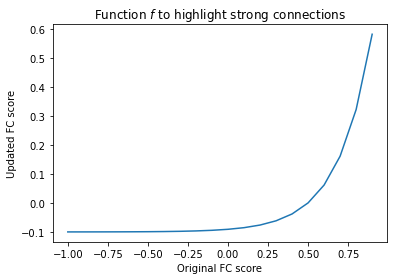

In [41]:
# (Optional) function to map [-1,1] -> [-0.1, 1] 
# It drastically decreases resolution for [-1,0.5] range
# Motivation: we are interested only in highly connected links
f = lambda t: -0.1 + 0.00909091*121**t
plt.plot(np.arange(-1,1,0.1), f(np.arange(-1,1,0.1)))
plt.xlabel('Original FC score')
plt.ylabel('Updated FC score')
plt.title('Function $f$ to highlight strong connections');

In [42]:
def get_coh(x, fs):
    x = torch.tensor(x) # to do repeat operations
    N, D = x.shape
    pxy = csd(torch.repeat_interleave(x, repeats = N, dim = 0), x.repeat(N,1), D)[-1].sum(-1).reshape(N,N)
    pxx = np.repeat(csd(x, x, fs)[-1].sum(-1), N).reshape(N,N)
    pyy = np.repeat(csd(x, x, fs)[-1].sum(-1), N).reshape(N,N).T
    coh = pxy/np.sqrt(pxx*pyy)
    return coh

def get_plv(x):
    N, D = x.shape
    phi_x = torch.repeat_interleave(torch.tensor(np.angle(np.fft.fft(x))), repeats = N, dim = 0)
    phi_y = torch.tensor(np.angle(np.fft.fft(x))).repeat(N,1)
    return (np.abs(np.exp(-1j*(phi_x-phi_y)).sum(-1))/D).reshape(N,N)

In [43]:
def get_fc(eeg_data, fs = None, method = 'corr', EPS = 1e-3):
    """
    Input: 
        eeg_data (np.array): raw EEG data with N channels and D length
        fs (float): sampling frequency
        method (str): 'lps', 'rcoh', 'plv' or 'corr' - Lagged Phase Synchronization, Real(Coherence), Phase Locking Value, Pearson correlation
        EPS (float): constant for numerical stability 
    Output:
        functional connectivity matrix
    """
    N, D = eeg_data.shape
    if method == 'corr':
        fc_adj = np.corrcoef(eeg_data)
        fc_adj = f(fc_adj) # Highligting strong connections
        fc_adj = fc_adj - np.eye(N,N) #Remove self-self connections
    elif method == 'plv':
        fc_adj = get_plv(eeg_data)
        #fc_adj = f(fc_adj) # Highligting strong connections
        fc_adj = fc_adj - np.eye(N,N) #Remove self-self connections
    else:
        coh = get_coh(eeg_data, fs)
        if method == 'rcoh':
            fc_adj = np.real(coh)
            fc_adj = f(fc_adj) # Highligting strong connections
            fc_adj = fc_adj - np.eye(N,N) #Remove self-self connections
        elif method == 'lps':
            fc_adj = np.abs(np.imag(coh))/np.sqrt(1-np.real(coh)**2 + EPS)
        else:
            raise NotImplementedError
    return fc_adj

### Creating data sets

In [44]:
hc_dataset_raw, sz_dataset_raw, avh_dataset_raw = dataset_raw # given raw data
hc_dataset, sz_dataset, avh_dataset = [], [], [] # data sets to train a model

In [45]:
for patient_data in hc_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,0,0] # resting, no schizophrenia, no hallucinations
        y_1 = [1,0,0] # listening, no schizophrenia, no hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        hc_dataset.append(data_0)
        hc_dataset.append(data_1)
        
# Repeat for SZ patients        
for patient_data in sz_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,1,0] # resting, schizophrenia, no hallucinations
        y_1 = [1,1,0] # listening, schizophrenia, no hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        sz_dataset.append(data_0)
        sz_dataset.append(data_1)
        
# Repeat for AVH patients        
for patient_data in sz_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,1,1] # resting, schizophrenia, hallucinations
        y_1 = [1,1,1] # listening, schizophrenia, hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        avh_dataset.append(data_0)
        avh_dataset.append(data_1)

In [46]:
# Random permuation of data (in-place)
random.shuffle(hc_dataset)
random.shuffle(sz_dataset)
random.shuffle(avh_dataset)

### Forming the final data set

In [47]:
# there are more healthy people
# => for equal representation take only a subset from HC and SZ data sets
hc_dataset = hc_dataset[:len(avh_dataset)]
sz_dataset = sz_dataset[:len(avh_dataset)]

In [48]:
dataset = hc_dataset + sz_dataset + avh_dataset

In [49]:
#torch.save(dataset, 'dataset')

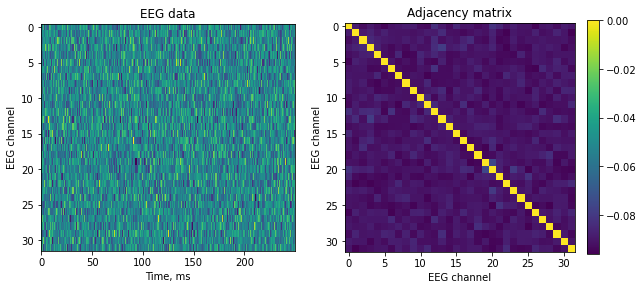

In [50]:
# Let us visualize both EEG data and FC data of a randomly taken data point
data = random.choice(dataset)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [10,10])

ax1.imshow(data.x, interpolation = 'nearest', aspect = 7.)
ax1.set_xlabel('Time, ms')
ax1.set_ylabel('EEG channel')
ax1.set_title('EEG data')

im = ax2.imshow(data.adj[0])
ax2.set_xlabel('EEG channel')
ax2.set_ylabel('EEG channel')
ax2.set_title('Adjacency matrix')
fig.colorbar(im, fraction = 0.046);

### Train/test split

In [51]:
random.shuffle(dataset)

train_dataset = dataset[:8*len(dataset)//10] # First 80% of data
test_dataset = dataset[8*len(dataset)//10:] # Last 20% of data

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

Number of training graphs: 1728
Number of test graphs: 432


/home/zhdano82/.conda/envs/geometric/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training a model

In [52]:
from model import ccVAE
from utils import train

In [53]:
# A class containing hyperparameters of a model. Mimics argsparse.
class Args():
    def __init__(self, z_dim = 10, w_dim = 10):
        self.n_nodes = N
        self.x_dim = 250
        self.n_classes = 3 # len(y)
        self.drop_rate = 0.
        
        self.z_dim = z_dim
        self.w_dim = w_dim
        
        self.elbo_coefs = [1.,2.,10.] # beta_z, beta_w, alpha_classifier (see Thesis, 3.3.2)
        self.decoder_w_mode = 'conv'
        self.cond_prior_w_mode = 'lookup'
        self.cond_prior_z_mode = 'lookup'
        
        self.use_cuda = 1 if torch.cuda.is_available() else 0

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [55]:
# Initialize model
args = Args()
model = ccVAE(args)
if device == 'cuda':
    model = model.cuda()

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [57]:
# Let us train a model now
n_epochs = 1
for epoch in range(n_epochs):
    train(model, optimizer, train_loader, True, device, 1) # training procedure
    if epoch % 5 == 0:
        train(model, optimizer, test_loader, False, device, 1) # testing procedure

ELBO 8506.98, Accuracy y: [0.48, 0.68, 0.29] MSE X: 84.42, MSE A: 2.55, KL Z: 180.83, KL W: 5.41, log q(y|X,A): 0.03, 
Test
ELBO 8528.99, Accuracy y: [0.56, 0.61, 0.38] MSE X: 121.01, MSE A: 2.48, KL Z: 184.60, KL W: 5.84, log q(y|X,A): 0.02, 


## Interpreting latent variables

In [58]:
import torch.distributions as dist

In [59]:
def var_interv(model, label_values, ind_to_vary, device, n_interventions = 1000):
    """
    Input: 
        model: trained CGVAE model (CCVAE-AX or CCVAE-A).
        label_values (torch.tensor): tensor of shape [1, #labels] with fixed values of labels.
        ind_to_vary (int): index of dimensions which is to be intervened upon.
        device (str): 'cuda' or 'cpu'.
        n_interventions (int): number of interventions to perform.
    Output:
        N x N matrix where each element is variance of FC value after n_interventions.
    """
    with torch.no_grad():
        bs = n_interventions
        label_values = label_values.expand(n_interventions, -1).clone()
        y_i = torch.randint(2,[n_interventions]) # random binary value
        label_values[:, ind_to_vary] = y_i
        y = label_values.to(device)
        locs_pwc_y, scales_pwc_y = model.cond_prior_w(y)
        prior_params_w = (torch.cat([locs_pwc_y, model.zeros_w.expand(bs, -1)], dim=-1), 
                          torch.cat([scales_pwc_y, model.ones_w.expand(bs, -1)], dim=-1))
        pw_y = dist.Normal(*prior_params_w)
        w_ = pw_y.sample()
        w = pw_y.loc
        w[:,ind_to_vary] = w_[:,ind_to_vary]
        pa_w = dist.Normal(*model.decoder_w(w))
    return pa_w.loc.squeeze().var(0)

In [60]:
label_values = torch.tensor([0,0,0]) # default values of labels (fixing dimensions)
ind_to_vary = 0 # index of the label which is to be intervened upon
n_interventions = 1000

In [62]:
var_A = var_interv(model, label_values, ind_to_vary, device).cpu().detach()

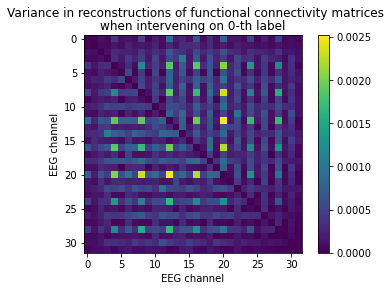

In [63]:
plt.imshow(var_A)
plt.colorbar()
plt.suptitle('Variance in reconstructions of functional connectivity matrices')
plt.title(f'when intervening on {ind_to_vary}-th label')
plt.xlabel('EEG channel')
plt.ylabel('EEG channel');

In [64]:
def highest_connections(var_A, channel_names, n):
    """
    Function to print which connections have the highest variance values
    Input:
        var_A (torch.tensor): N x N matrix where each element is variance of FC value after n_interventions.
        channel_names (numpy.array): array with names of electrodes in the same order as in var_A
        n (int): number of connections to print
    """
    print('Connections with highest variance:')
    for i,pair in enumerate(list(np.dstack(np.unravel_index(np.argsort(var_A.ravel()), (N, N)))[0,-(n*2):,:])[::-1]):
        if i % 2 == 0: # since FC matrices are symmetrical we skip different directions
            print('     ' + str(channel_names[pair]) + 
                  f': {var_A[pair[0], pair[1]].item():.3f}') 

In [65]:
# For example purpose I initialize EEG channel names with random channels
import string
random_chars = [random.choice(string.ascii_uppercase + string.digits) for _ in range(N)]
channel_names = np.array(random_chars) # substitute with true names when given

In [66]:
print(f'Intervening on {ind_to_vary}-th label.')
highest_connections(var_A, channel_names, 10)

Intervening on 0-th label.
Connections with highest variance:
     ['X' 'M']: 0.003
     ['0' 'M']: 0.002
     ['M' '0']: 0.002
     ['M' '4']: 0.002
     ['X' '0']: 0.002
     ['X' '0']: 0.002
     ['0' '4']: 0.002
     ['4' 'X']: 0.002
     ['0' '0']: 0.002
     ['X' 'Z']: 0.002


## Testing NLL

In [67]:
import itertools

### log p(X|Z,A) for each y

In [69]:
nll = {}
# all possible combinations of labels
labels = [torch.tensor([y]).float() for y in itertools.product([0,1], repeat=args.n_classes)]
for y in labels:
    # all instances with y label in test dataset
    test_dataset_y = [data for data in test_dataset if (data.y == y).prod()]
    if len(test_dataset_y):
        test_loader_y = DataLoader(test_dataset_y, batch_size=100000, shuffle=True, drop_last=False)
        bs = len(test_dataset_y)
        data = next(iter(test_loader_y)).to(device)
        # inference model q(Z|X)
        qz_x = dist.Normal(*model.encoder_x(data.x))
        z = qz_x.rsample([1])  
        # likelihood model p(X|Z,A)
        px_za = dist.Normal(*model.decoder_za(z, data.adj))
        # log p(X|Z,A) 
        log_px_za = px_za.log_prob(data.x.view(bs,model.n_nodes,model.x_dim))
        nll[str(y[0].long().tolist())] = log_px_za.sum(-1).sum(-1).mean().item()

In [70]:
for key, value in nll.items():
    print(f'y: {key} -> NLL p(X|Z,A): {value:.1f}')

y: [0, 0, 0] -> NLL p(X|Z,A): -7378.2
y: [0, 1, 0] -> NLL p(X|Z,A): -7378.1
y: [0, 1, 1] -> NLL p(X|Z,A): -7378.0
y: [1, 0, 0] -> NLL p(X|Z,A): -7378.0
y: [1, 1, 0] -> NLL p(X|Z,A): -7378.1
y: [1, 1, 1] -> NLL p(X|Z,A): -7378.1


### log p(A|w) for each y

In [71]:
nll = {}
# all possible combinations of labels
labels = [torch.tensor([y]).float() for y in itertools.product([0,1], repeat=args.n_classes)]
for y in labels:
    # all instances with y label in test dataset
    test_dataset_y = [data for data in test_dataset if (data.y == y).prod()]
    if len(test_dataset_y):
        test_loader_y = DataLoader(test_dataset_y, batch_size=100000, shuffle=True, drop_last=False)
        bs = len(test_dataset_y)
        data = next(iter(test_loader_y)).to(device)
        # inference model q(w|A)
        qw_a = dist.Normal(*model.encoder_a(data.adj))
        w = qw_a.rsample([1])  
        # likelihood model p(A|w)
        pa_w = dist.Normal(*model.decoder_w(w))
        # log p(X|Z,A) 
        log_pa_w = pa_w.log_prob(data.adj)
        nll[str(y[0].long().tolist())] = log_pa_w.sum(-1).sum(-1).mean().item()

In [72]:
for key, value in nll.items():
    print(f'y: {key} -> NLL p(A|w): {value:.1f}')

y: [0, 0, 0] -> NLL p(A|w): -937.9
y: [0, 1, 0] -> NLL p(A|w): -937.9
y: [0, 1, 1] -> NLL p(A|w): -937.9
y: [1, 0, 0] -> NLL p(A|w): -937.9
y: [1, 1, 0] -> NLL p(A|w): -937.9
y: [1, 1, 1] -> NLL p(A|w): -937.9
